In [91]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [93]:
df=pd.read_csv('/content/drive/MyDrive/WOC_6.0/Neural_Network/Classification_train.csv')
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29998,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
a=df.shape[0]
a -= 5000
x_train=np.array(df.iloc[0:a,1:] , dtype = np.int32)
y_train=np.array(df.iloc[0:a,0:1] , dtype = np.int16)
x_val=np.array(df.iloc[a:,1:] , dtype = np.int32)
y_val=np.array(df.iloc[a:,0:1] , dtype = np.int16)
x_train.shape,y_train.shape

((25000, 784), (25000, 1))

In [95]:
x_train = x_train/255
x_val = x_val/255

In [140]:
class NeuralNetwork:
  def __init__(self, layers, learning_rate, epochs , seed):
      self.layers = layers
      self.learning_rate = learning_rate
      self.epochs = epochs
      self.weights = []
      self.bias = []
      self.loss_history = []
  def initialize_parameters(self):
      np.random.seed(seed)  # For reproducibility
      for i in range(1,len(self.layers)):
          self.weights.append(np.random.randn(self.layers[i], self.layers[i-1]) * 0.01)
          self.bias.append(np.zeros((self.layers[i], 1)))
  def relu(self, Z):
      return np.maximum(0, Z)
  def softmax(self, Z):
      exp_Z = np.exp(Z - np.max(Z))  # Stability trick
      return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
  def forward_propagation(self, X, ):
      caches = [(X.T,X.T)]
      A = X.T
      for i in range(len(self.layers) - 2): #For Hidden Layers
          Z = np.dot(self.weights[i], A) + self.bias[i]
          A = self.relu(Z)
          caches.append((A, Z))
      #For output layer
      Z_output = np.dot(self.weights[len(self.layers)-2], A) + self.bias[len(self.layers)-2]
      A_output = self.softmax(Z_output)
      caches.append((A_output, Z_output))
      return A_output, caches
  def compute_cost(self, Y, X):
      m = Y.shape[1]
      Y_pred, caches = self.forward_propagation(X)
      cost = -np.sum(Y * np.log(Y_pred+1e-8)) / m
      return cost
  def backward_propagation(self, X, Y, caches):
    dW = [0]*len(self.weights)
    db = [0]*len(self.bias)
    m = X.shape[0]
    dZ_output = caches[-1][0] - Y
    dW[len(self.layers)-2] = np.dot(dZ_output , caches[-2][0].T) / m
    db[len(self.layers)-2] = np.sum(dZ_output, axis=1, keepdims=True) / m
    dA = np.dot(self.weights[len(self.layers)-2].T, dZ_output)
    for i in range(len(self.layers)-3, -1, -1):
        dZ = np.multiply(dA, np.where((caches[i+1][0]>0) , 1 , 0) )
        dW[i] = np.dot(dZ,caches[i][0].T) / m
        db[i] = np.sum(dZ, axis=1, keepdims=True) / m
        dA = np.dot(self.weights[i].T, dZ)
    return dW , db

  def update_parameters(self, dW, db):
      for i in range(0, len(self.layers)-1):
          self.weights[i] -= self.learning_rate * dW[i]
          self.bias[i] -= self.learning_rate * db[i]

  def one_hot_encode(self,Y):
    features = np.unique(Y).shape[0]
    template = np.arange(0,features)
    one_hot_Y = np.where((Y==template),1,0).T
    return one_hot_Y

  def train(self, X_train, Y_train, batch_size=32):
      t1 = time.time()
      self.initialize_parameters()
      Y_train_one_hot = self.one_hot_encode(Y_train)
      last_epoch = 0
      for epoch in range(self.epochs+1):
          cost = self.compute_cost(Y_train_one_hot, X_train)
          accuracy = self.accuracy(X_train , Y_train)
          self.loss_history.append(cost)
          print(f"Epoch {epoch:3}/{self.epochs} | Cost: {cost:.13f} |  Accuracy: {accuracy:.6f}")
          if epoch == self.epochs:
            break
          last_epoch = epoch
          for i in range(0, X_train.shape[0], batch_size):
              X_batch = X_train[i:i+batch_size, :]
              Y_batch = Y_train_one_hot[:, i:i+batch_size]
              Y_pred, caches = self.forward_propagation(X_batch)
              dW , db = self.backward_propagation(X_batch, Y_batch, caches)
              self.update_parameters(dW, db)
      print(f"Training time: {time.time()-t1:.2f} " )
      self.plot_loss(last_epoch)

  def plot_loss(self, last_epoch):
      plt.plot(np.arange(last_epoch+2), self.loss_history)
      plt.title("Loss vs Epochs")
      plt.ylabel("Loss")
      plt.xlabel("epochs")

  def predict(self, X):
      Y_pred, _ = self.forward_propagation(X)
      return np.argmax(Y_pred, axis=0)

  def accuracy(self, X_test , y_true):
      Y_pred = self.predict(X_test)
      accuracy = np.mean(np.where((Y_pred == y_true.reshape(-1)),1,0))
      return accuracy

In [143]:
layers = [784, 512, 256, 128, 10]
learning_rate = 0.1
epochs = 25
seed = 42
model = NeuralNetwork(layers, learning_rate, epochs, seed)

Epoch   0/25 | Cost: 2.3025875483293 |  Accuracy: 0.136920
Epoch   1/25 | Cost: 2.3017448587940 |  Accuracy: 0.104320
Epoch   2/25 | Cost: 0.7299118064676 |  Accuracy: 0.715680
Epoch   3/25 | Cost: 0.1446333316191 |  Accuracy: 0.961760
Epoch   4/25 | Cost: 0.0818322512492 |  Accuracy: 0.978560
Epoch   5/25 | Cost: 0.0615991241733 |  Accuracy: 0.983200
Epoch   6/25 | Cost: 0.0397380007370 |  Accuracy: 0.988520
Epoch   7/25 | Cost: 0.0344485177688 |  Accuracy: 0.989680
Epoch   8/25 | Cost: 0.0208401159370 |  Accuracy: 0.993760
Epoch   9/25 | Cost: 0.0124983962144 |  Accuracy: 0.996680
Epoch  10/25 | Cost: 0.0218126566202 |  Accuracy: 0.992760
Epoch  11/25 | Cost: 0.0071276084914 |  Accuracy: 0.998720
Epoch  12/25 | Cost: 0.0066316476125 |  Accuracy: 0.998640
Epoch  13/25 | Cost: 0.0084976956271 |  Accuracy: 0.997960
Epoch  14/25 | Cost: 0.0066385774987 |  Accuracy: 0.998360
Epoch  15/25 | Cost: 0.0031565941884 |  Accuracy: 0.999320
Epoch  16/25 | Cost: 0.0091800434106 |  Accuracy: 0.9975

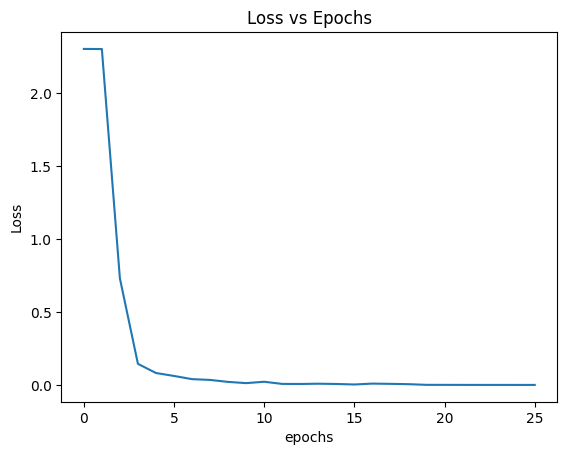

In [144]:
model.train(x_train, y_train, batch_size = 32)

In [145]:
model.accuracy(x_val, y_val)

0.9856

In [146]:
df1=pd.read_csv('/content/drive/MyDrive/WOC_6.0/Neural_Network/Classification_test.csv')
df1

,ID,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,15795,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5390,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11964,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11284,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,18563,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,634,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,10057,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
x_test = np.array(df1.iloc[:,1:] , dtype = np.int32)
id = np.array(df1.iloc[:,0] , dtype = int)
x_test = x_test/255

In [148]:
y_pred = model.predict(x_test)

In [149]:
submission = pd.DataFrame({"Id":id , "Output":y_pred})
submission

,Id,Output
0,15795,0
1,860,4
2,5390,5
3,11964,5
4,11284,9
...,...,...
9995,11260,9
9996,18563,9
9997,634,0
9998,10057,8


In [150]:
submission.to_csv("/content/drive/MyDrive/WOC_6.0/Neural_Network/Submission_nn.csv")